In [5]:
from pystencils.finitedifferences import *
from pystencils import Field
from pystencils.display_utils import to_dot
from pystencils.cpu import create_kernel, make_python_function
from lbmpy.session import *
sp.init_printing()
import sympy as sp
import numpy as np


In [6]:

size = (100,100)
dx = 1
dim = len(size)

# create arrays
uArrays = [np.zeros(size), np.zeros(size)]
uFields = [ Field.create_from_numpy_array("u^%s" % (name,),arr) 
            for name, arr in zip(["current", "next"],uArrays)]
pde = diffusion(uFields[0].center, 1)
#pde
#[x.field for x in pde.atoms() if isinstance(x, Field.Access)]
#toDot(pde)
#pde = diffusion(u.center, 1)
pde

In [28]:
disc = Discretization2ndOrder()
discretization = disc(pde).expand()
discretization = discretization.subs(sp.Symbol("dx"), dx)
update = sp.solve(discretization, uFields[0].center)
sp.srepr(update[0])
sp.expand(update[0])
stencil = update[0]
access = list(stencil.args[0].free_symbols)[0]
type(access.offsets)


tuple

In [16]:
u_next_C = uFields[1].center
ast = create_kernel([sp.Eq(u_next_C, update[0])])
kernel = ast.compile()
show_code(ast)

FUNC_PREFIX void func_b331ff1aae060b686f0ece8edf4839676a0bdc2cebee11fc8413c9edbafc066a(double * RESTRICT  const  fd_u_current, double * RESTRICT  fd_u_next)
{
   for (int ctr_0 = 1; ctr_0 < 99; ctr_0 += 1)
   {
      double * RESTRICT   fd_u_next_C = 100*ctr_0 + fd_u_next;
      double * RESTRICT  const   fd_u_current_E = 100*ctr_0 + fd_u_current + 100;
      double * RESTRICT  const   fd_u_current_C = 100*ctr_0 + fd_u_current;
      double * RESTRICT  const   fd_u_current_W = 100*ctr_0 + fd_u_current - 100;
      for (int ctr_1 = 1; ctr_1 < 99; ctr_1 += 1)
      {
         fd_u_next_C[ctr_1] = (0.25)*fd_u_current_C[ctr_1 + 1] + (0.25)*fd_u_current_C[ctr_1 - 1] + (0.25)*fd_u_current_E[ctr_1] + (0.25)*fd_u_current_W[ctr_1];
      }
   }
}

In [5]:
ast.fields_accessed

{u^current, u^next}

In [11]:
X,Y = np.meshgrid( np.linspace(0, 1, size[1]), np.linspace(0,1, size[0]))
#Z = np.sin(2*X*np.pi) * np.sin(2*Y*np.pi)
#Z = np.random.rand(size[0], size[1])
Z = np.ones(size)
np.copyto(uArrays[0], Z)
Z

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [19]:
def boundary_handling(u):
    # No concentration at the upper, lower wall and the left inflow border
    u[:, 0] = 0
    u[0, :] = 0
    u[:, -1] = 0
    u[-1, :] = 0

def run(timesteps):
    for t in range(timesteps):
        boundary_handling(uArrays[0])
        kernel(u_current=uArrays[0], u_next=uArrays[1])
        uArrays[0] = uArrays[1]
    return X, Y, uArrays[1]

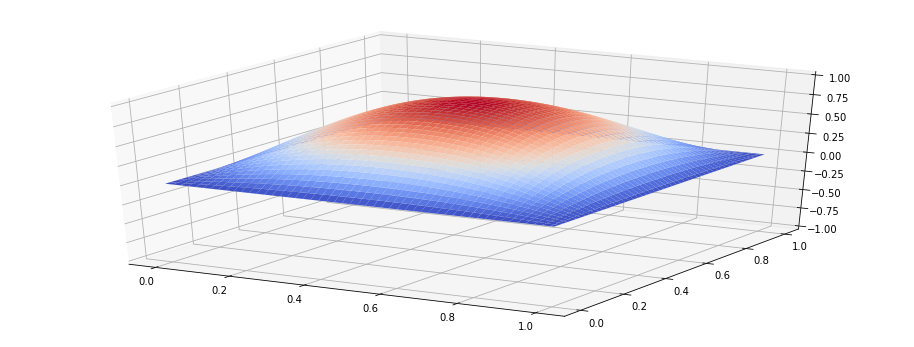

In [20]:
from pystencils.jupytersetup import make_surface_plot_animation, display_in_extra_window
ani = make_surface_plot_animation(run, frames=200)
display_in_extra_window(ani)